In [2]:
import numpy as np
from scipy import signal, interpolate
import quaternion

import matplotlib.pyplot as plt

from copy import copy

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session
plt.rcParams['axes.formatter.useoffset'] = False

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from test_imu_algorithms import IMU_test_data

Set up test data from 0 to 50 seconds at 200Hz

In [5]:
imu = IMU_test_data((0, 50, 1.0/200))

Initial chip orientation

In [6]:
roll0 = np.deg2rad(-85) # (-85)
pitch0 = np.deg2rad(82) # (-93)
yaw0 = np.deg2rad(0)

In [7]:
Rx = np.array([[1, 0, 0],
               [0, np.cos(roll0), np.sin(roll0)],
               [0, -np.sin(roll0), np.cos(roll0)]])
Ry = np.array([[np.cos(pitch0), 0, np.sin(pitch0)],
               [0, 1, 0],
               [-np.sin(pitch0), 0, np.cos(pitch0)]])
Rz = np.array([[np.cos(yaw0), np.sin(yaw0), 0],
               [-np.sin(yaw0), np.cos(yaw0), 0],
               [0, 0, 1]])

R0 = Rx.dot(Ry.dot(Rz))
imu.set_initial_orientation(R0)

In [8]:
np.round(R0, decimals=3)

array([[ 0.139,  0.   ,  0.99 ],
       [ 0.986,  0.087, -0.139],
       [-0.086,  0.996,  0.012]])

In [9]:
r, p, y = imu._rotm2eul(R0)
print np.rad2deg([r, p, y])

[-85.  82.   0.]


Set up noise parameters

In [10]:
imu.set_noise_params(gyrorms=1.0,          # deg/sec
                     gyrofreq=20.0,        # Hz
                     gyrodriftrms=0.0,     # deg/sec
                     gyrodriftfreq=0.1,    # Hz
                     accrms=0.03,          # g
                     accfreq=33)           # Hz

Generate the arm data

In [11]:
imu.generate_arm_data(alpham=np.deg2rad(15), # 15deg
                      Am=0.15, # 0.15m back and forth
                      f=0.7, # 0.7Hz oscillation
                      l=0.4,
                      delta=0.2) # 20% phase lag between angle and forward back motion

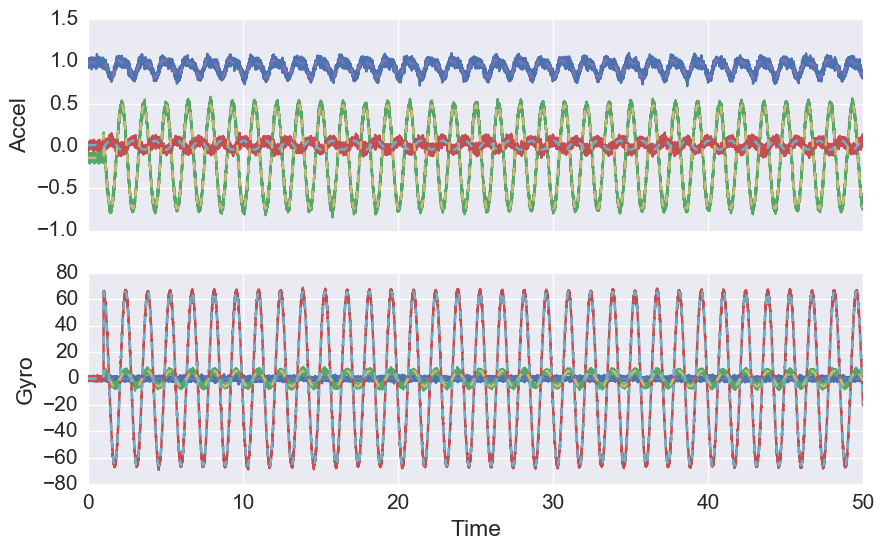

In [12]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(imu.t, imu.acc0)
ax[0].plot(imu.t, imu.acc_nonoise, '--')
ax[0].set_ylabel('Accel')

ax[1].plot(imu.t, imu.gyro0)
ax[1].plot(imu.t, imu.gyro_nonoise, '--')
ax[1].set_ylabel('Gyro')
ax[1].set_xlabel('Time')
# ax[0].set_xlim([0, 5])
plt.show()

Set up initial orientation for EKF algorithm

In [13]:
imu.filter(nsamp=10, method='running')

imu.calibrate(duration=30.0)
imu.get_inertial_coords(duration=30.0)
imu.get_world_coordinates(duration=30.0)

/Users/etytel01/anaconda/lib/python2.7/site-packages/numpy/lib/shape_base.py:873: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return c.reshape(shape_out)


Check how close the estimated chip orientation is to the real chip orientation

In [14]:
print "Estimated orientation:\n{}".format(np.round(imu.chip2world_rot, decimals=3))
print "\nTrue orientation:\n{}".format(np.round(imu.R0, decimals=3))

print "\nDifference:\n{}".format(np.round(imu.chip2world_rot - imu.R0, decimals=5))
print "\nNorm of difference: {}".format(np.linalg.norm(imu.chip2world_rot - imu.R0))

Estimated orientation:
[[ 0.139  0.002  0.99 ]
 [ 0.987  0.086 -0.138]
 [-0.086  0.996  0.01 ]]

True orientation:
[[ 0.139  0.     0.99 ]
 [ 0.986  0.087 -0.139]
 [-0.086  0.996  0.012]]

Difference:
[[ -4.90000000e-04   1.54000000e-03   7.00000000e-05]
 [  1.30000000e-04  -9.60000000e-04   3.50000000e-04]
 [  7.30000000e-04   8.00000000e-05  -1.69000000e-03]]

Norm of difference: 0.00265851890433


In [15]:
imu.get_orientation(method='ekf', lCa=(0.0, -0.3, -0.7))
orient_ekf = copy(imu.orient_world)
orient_ekf_chip = copy(imu.orient_sensor)
accdyn_ekf = copy(imu.accdyn_world)
accdyn_ekf_chip = copy(imu.accdyn_sensor)

In [16]:
imu.filter(method='butter', order=5, gyro_cutoff=(0.1, 10), acc_cutoff=(0, 30))

dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


In [17]:
imu.get_orientation(method='madgwick')
orient_mad = copy(imu.orient_world)
orient_mad_chip = copy(imu.orient_sensor)
accdyn_mad = copy(imu.accdyn_world)
accdyn_mad_chip = copy(imu.accdyn_sensor)
qorient_mad = copy(imu.qorient)

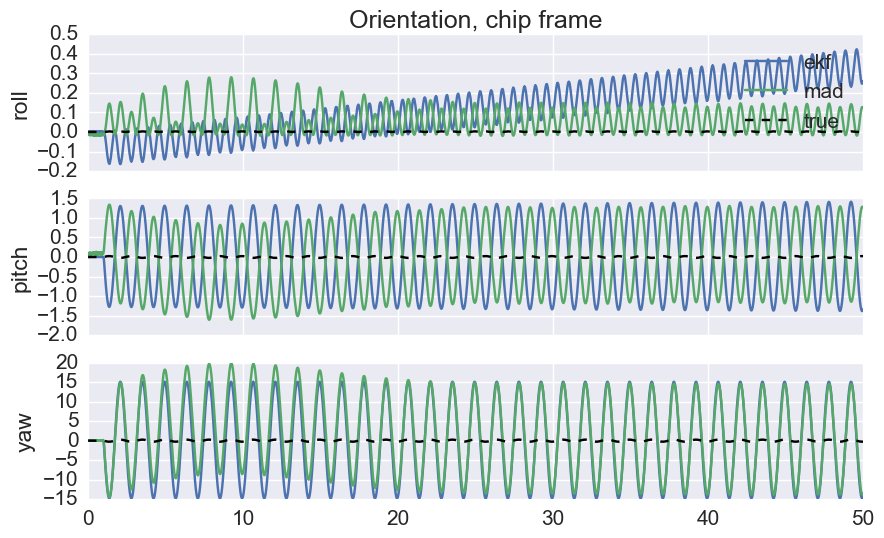

In [20]:
fig, ax = plt.subplots(3,1, sharex=True)
for o0, oe, om, ax1, lab in zip(np.rollaxis(imu.orient_imu_true, 1), 
                                np.rollaxis(orient_ekf_chip, 1),
                                np.rollaxis(orient_mad_chip, 1),
                                ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, -np.rad2deg(oe), label='ekf')
    ax1.plot(imu.t, np.rad2deg(om), label='mad')
    ax1.plot(imu.t, o0, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('Orientation, chip frame')
ax[0].legend()
#ax[0].set_xlim([4.5, 5])

In [21]:
def get_error(imu):
    qerr = np.array([2*np.arccos(np.abs(np.sum(q1.components * q2.components))) 
            for q1, q2 in zip(imu.qorient_world, imu.qorient_world_true)])
    qerr = np.nanmean(qerr)
    
    oerr = np.sqrt(np.mean(np.square(imu.orient_world - imu.orient_world_true), axis=0))
    
    return qerr, oerr

In [116]:
imu.filter(method='butter', order=5, gyro_cutoff=(0.1, 10), acc_cutoff=(0, 30))

dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


In [117]:
imu.get_orientation(method='valenti', gain=0.0, gainrange=None)
orient_val_gyro = copy(imu.orient_world)

imu.get_orientation(method='valenti', gain=1.0, gainrange=None)
orient_val_acc = copy(imu.orient_world)

In [118]:
imu.get_orientation(method='valenti', gain=0.1, gainrange=(0.01, 0.05))

array([[ -0.00000000e+00,  -5.55111512e-17,  -0.00000000e+00],
       [  2.96015213e-05,   1.22491516e-04,   8.64453013e-06],
       [  4.52524799e-05,   2.65380117e-04,   1.49213016e-05],
       ..., 
       [  1.28083452e-04,  -2.78140311e-01,   1.17650002e-04],
       [  1.59473978e-04,  -2.76613009e-01,   7.78573702e-05],
       [  1.98354852e-04,  -2.74963274e-01,   2.76407059e-05]])

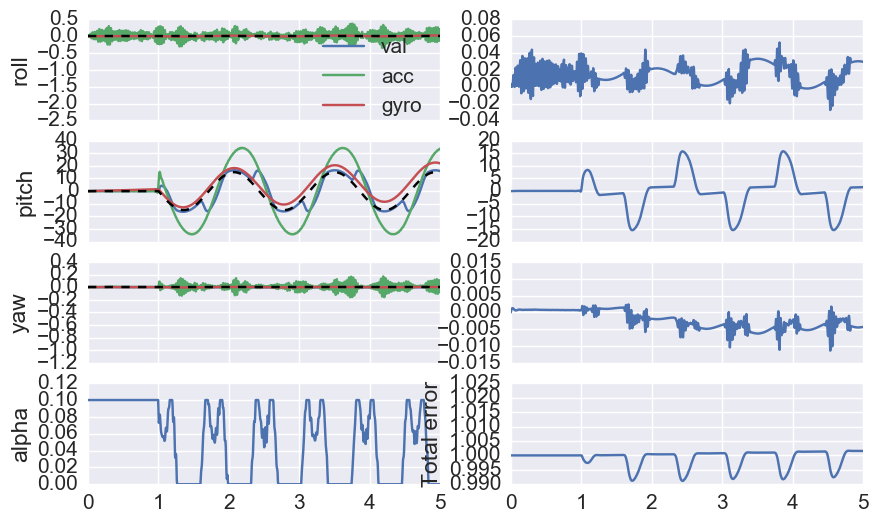

In [119]:
fig, ax = plt.subplots(4,2, sharex=True)
for o0, ov, ova, ovg, ax1, lab in zip(np.rollaxis(imu.orient_world_true, 1), np.rollaxis(imu.orient_world, 1),
                                    np.rollaxis(orient_val_acc, 1), np.rollaxis(orient_val_gyro, 1), 
                                ax[:,0], ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, np.rad2deg(ov), label='val')
    ax1.plot(imu.t, np.rad2deg(ova), label='acc')
    ax1.plot(imu.t, np.rad2deg(ovg), label='gyro')    
    ax1.plot(imu.t, np.rad2deg(o0), 'k--')
    ax1.set_ylabel(lab)
    
ax[0,0].legend()

for o0, ov, ax1, lab in zip(np.rollaxis(imu.orient_world_true, 1), np.rollaxis(imu.orient_world, 1), 
                                ax[:,1], ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, np.rad2deg(ov-o0))

ax[3,0].plot(imu.t, imu.alpha)
ax[3,0].set_ylabel('alpha')

err = np.sum(quaternion.as_float_array(imu.qorient_world_true) * quaternion.as_float_array(imu.qorient_world), axis=1)
ax[3,1].plot(imu.t, err)
ax[3,1].set_ylabel('Total error')

ax[3,1].set_xlim(0,5)
plt.show()

Conclusion: The Valenti algorithm is doing what it should, but in this case, the raw accelerometer angle is never a very good estimate, so the complementary filter isn't a good idea.

According to the paper, the optimal beta parameter is $$\sqrt{0.75} \tilde{\omega}_{max}$$
where the omega parameter is the maximum gyro error on any axis.  We'll take that as the 2*standard deviation of the gyro in a stationary setting.

In [22]:
imu.filter(method='butter', order=9, gyro_cutoff=(0.1, 10), acc_cutoff=(0, 30))

dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


In [23]:
beta = np.rad2deg(np.sqrt(0.75) * np.max(2*imu.gyro_noise))
print "Gyro noise = {}.  Beta = {}".format(np.rad2deg(imu.gyro_noise), beta)

Gyro noise = [ 0.99999999  1.          1.        ].  Beta = 1.7320508065


In [24]:
imu.get_orientation(method='madgwick', beta=beta)

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.73050042e-04,  -9.37278273e-06,   2.45522724e-06],
       [  3.59190959e-04,   8.55365512e-06,   4.38861979e-06],
       ..., 
       [  1.78176858e-03,  -2.38338012e-01,  -6.91537478e-06],
       [  1.89767689e-03,  -2.37017155e-01,  -2.25555363e-05],
       [  2.05706272e-03,  -2.35529100e-01,  -3.87518797e-05]])

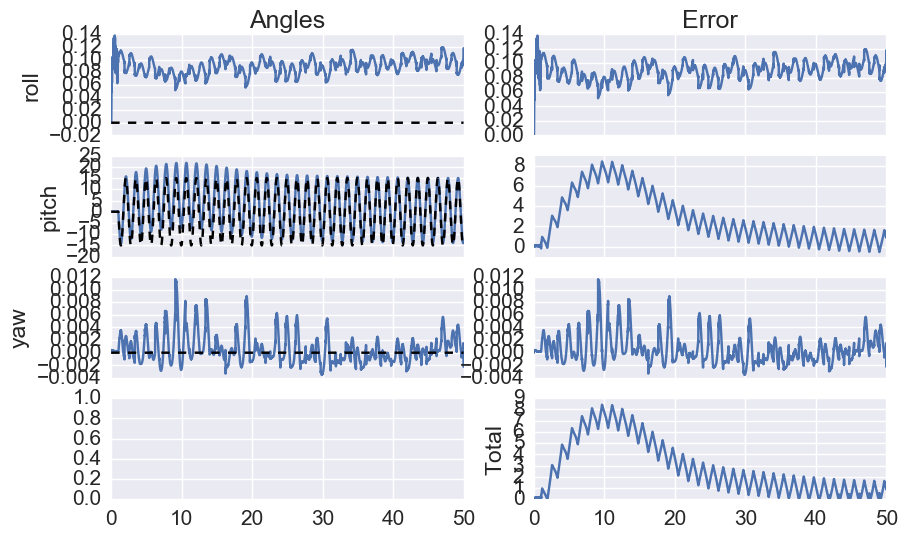

In [26]:
fig, ax = plt.subplots(4,2, sharex=True)
for o0, om, ax1, lab in zip(np.rollaxis(imu.orient_world_true, 1), np.rollaxis(imu.orient_world, 1),
                                ax[:,0], ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, np.rad2deg(om), label='mad')
    ax1.plot(imu.t, np.rad2deg(o0), 'k--')
    ax1.set_ylabel(lab)
ax[0,0].set_title('Angles')
    
for o0, om, ax1, lab in zip(np.rollaxis(imu.orient_world_true, 1), np.rollaxis(imu.orient_world, 1), 
                                ax[:,1], ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, np.rad2deg(om-o0))
ax[0,1].set_title('Error')

err = np.sqrt(np.sum(np.square(imu.orient_world - imu.orient_world_true), axis=1))
ax[3,1].plot(imu.t, np.rad2deg(err))
ax[3,1].set_ylabel('Total')

# ax[3,1].set_xlim(15,17)
plt.show()

In [27]:
betarng = np.arange(0, 10, 0.5)
qerr = []
oerr = []
for i, beta1 in enumerate(betarng):
    # print "beta = {} ({}%)".format(beta1, np.round(float(i)/len(betarng)*100))
    imu.get_orientation(method='madgwick', beta=beta1)
    
    qerr1, oerr1 = get_error(imu)
    qerr.append(qerr1)
    oerr.append(oerr1)
    
qerr = np.array(qerr)
oerr = np.array(oerr)

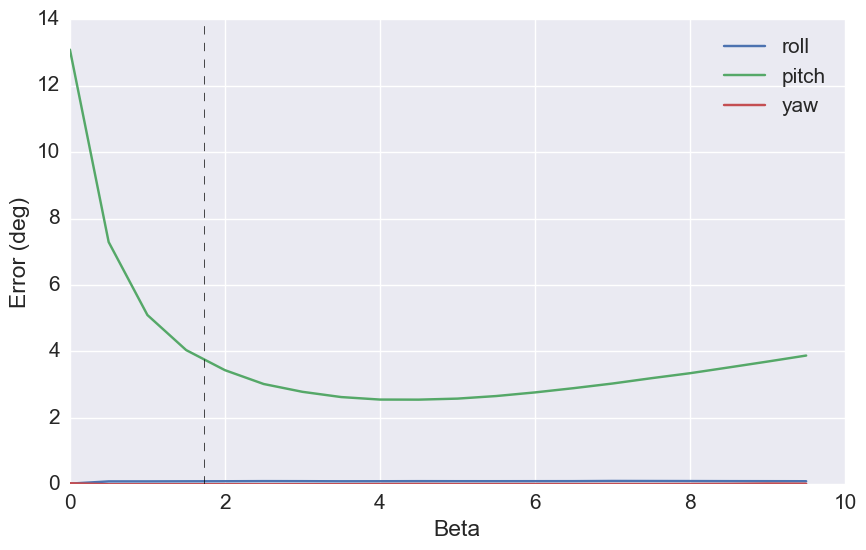

In [28]:
plt.plot(betarng, np.rad2deg(oerr[:,0]), label='roll')
plt.plot(betarng, np.rad2deg(oerr[:,1]), label='pitch')
plt.plot(betarng, np.rad2deg(oerr[:,2]), label='yaw')
plt.axvline(beta, color='k', linestyle='--', linewidth=0.5)
plt.legend()
plt.ylabel('Error (deg)')
plt.xlabel('Beta')
plt.show()

In [29]:
imu.filter(nsamp=10, method='running')
# imu.filter(method='butter', order=9, gyro_cutoff=(0.1, 10), acc_cutoff=(0, 30))

imu.calibrate(duration=30.0)
imu.get_inertial_coords(duration=30.0)
imu.get_world_coordinates(duration=30.0)

In [30]:
imu.get_orientation(method='ekf', lCa=(0.0, -0.3, -0.7))

array([[  4.79016108e-07,  -4.25388054e-06,   7.66117896e-07],
       [  4.79016108e-07,  -4.25388054e-06,   7.66117896e-07],
       [ -5.84237650e-06,  -7.40055589e-06,  -9.28062930e-06],
       ..., 
       [ -8.47850632e-04,  -2.51973440e-01,  -7.23180554e-03],
       [ -8.51511324e-04,  -2.50987534e-01,  -7.23862512e-03],
       [ -8.64569392e-04,  -2.50074517e-01,  -7.24623801e-03]])

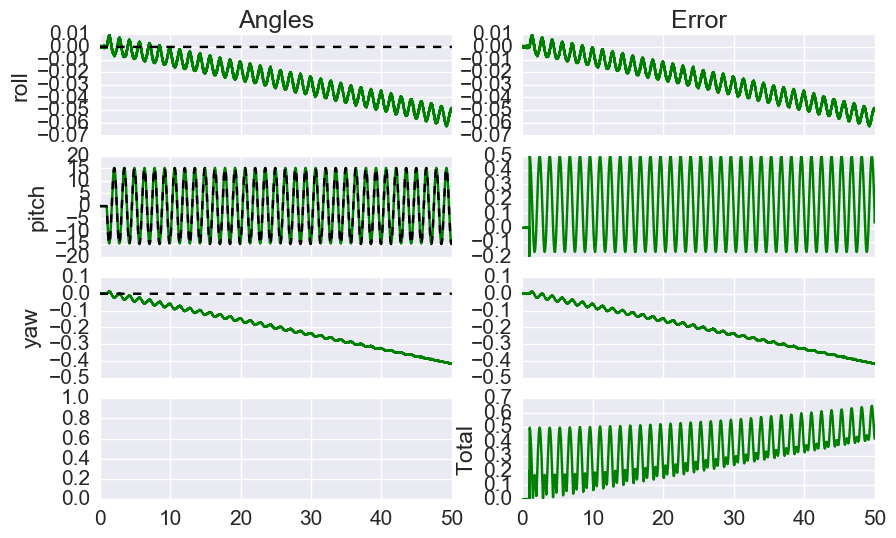

In [31]:
fig, ax = plt.subplots(4,2, sharex=True)
for o0, om, ax1, lab in zip(np.rollaxis(imu.orient_world_true, 1), np.rollaxis(imu.orient_world, 1),
                                ax[:,0], ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, np.rad2deg(om), 'g', label='mad')
    ax1.plot(imu.t, np.rad2deg(o0), 'k--')
    ax1.set_ylabel(lab)
ax[0,0].set_title('Angles')
    
for o0, om, ax1, lab in zip(np.rollaxis(imu.orient_world_true, 1), np.rollaxis(imu.orient_world, 1), 
                                ax[:,1], ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, np.rad2deg(om-o0), 'g')
ax[0,1].set_title('Error')

err = np.sqrt(np.sum(np.square(imu.orient_world - imu.orient_world_true), axis=1))
ax[3,1].plot(imu.t, np.rad2deg(err), 'g')
ax[3,1].set_ylabel('Total')

# ax[3,1].set_xlim(15,17)
plt.show()

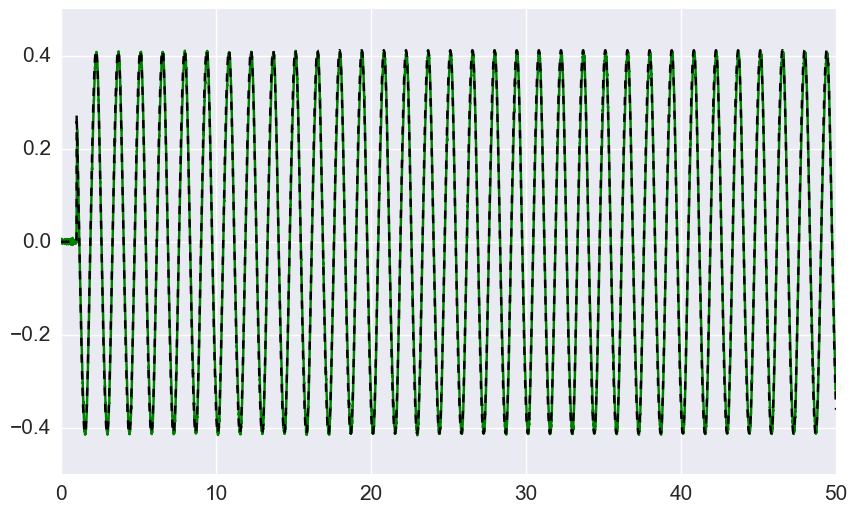

In [32]:
fig, ax = plt.subplots()
ax.plot(imu.t, imu.accdyn_world[:, 0], 'g')
ax.plot(imu.t, imu.accdyn_world_true[:, 0], 'k--')
plt.show()

In [39]:
Carng = np.arange(0, 20, 2)

pitch = []
accdyn = []
err = []
for i, Ca1 in enumerate(Carng):
    print "lCa = {} ({}%)".format(Ca1, np.round(float(i)/len(Carng)*100))
    imu.get_orientation(method='ekf', lCa=(Ca1, Ca1, Ca1))
    
    pitch.append(imu.orient_world[:, 1])
    accdyn.append(imu.accdyn_world[:, 0])
    
    qerr, oerr = get_error(imu)
    err.append(oerr)

pitch = np.array(pitch)
accdyn = np.array(accdyn)
err = np.array(err)

lCa = 0 (0.0%)


lCa = 2 (10.0%)


lCa = 4 (20.0%)


lCa = 6 (30.0%)


lCa = 8 (40.0%)


lCa = 10 (50.0%)


lCa = 12 (60.0%)


lCa = 14 (70.0%)


lCa = 16 (80.0%)


lCa = 18 (90.0%)


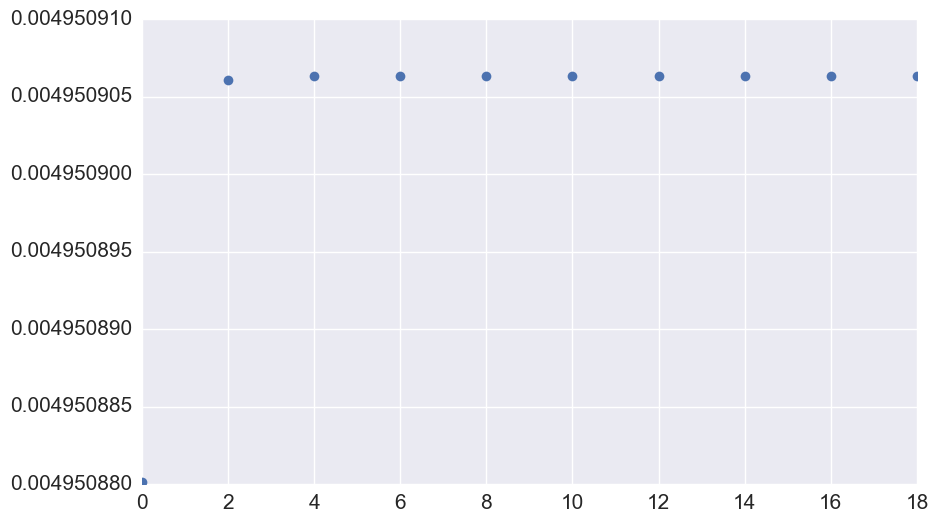

In [41]:
plt.plot(Carng, err[:, 1], 'o')

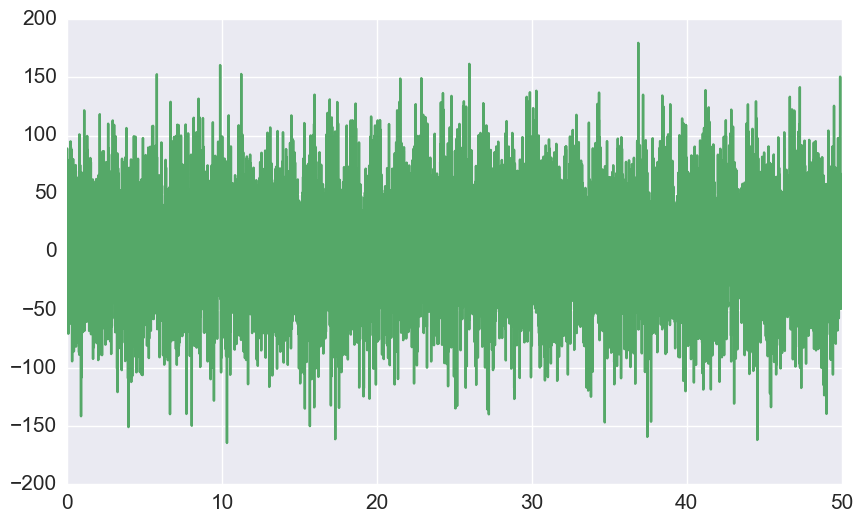

In [50]:
plt.plot(imu.t, accdyn[-2:,:].T)

In [14]:
imu.get_orientation(method='ekf', lCa=(0.0, -0.3, -0.7))
orient_ekf = copy(imu.orient_world)
orient_ekf_chip = copy(imu.orient_sensor)
accdyn_ekf = copy(imu.accdyn_world)
accdyn_ekf_chip = copy(imu.accdyn_sensor)

In [15]:
imu.filter(method='butter', order=5, gyro_cutoff=(0.1, 10), acc_cutoff=(0, 30))

dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


In [29]:
imu.get_orientation(method='valenti', gain=1.0, gainrange=None)
orient_val = copy(imu.orient_world)
accdyn_val = copy(imu.accdyn_world)
accdyn_val_chip = copy(imu.accdyn_sensor)
orient_val_chip = copy(imu.orient_sensor)
qorient_val = copy(imu.qorient_world)

In [30]:
imu.get_orientation(method='madgwick')
orient_mad = copy(imu.orient_world)
orient_mad_chip = copy(imu.orient_sensor)
accdyn_mad = copy(imu.accdyn_world)
accdyn_mad_chip = copy(imu.accdyn_sensor)
qorient_mad = copy(imu.qorient_world)

(0, 4)

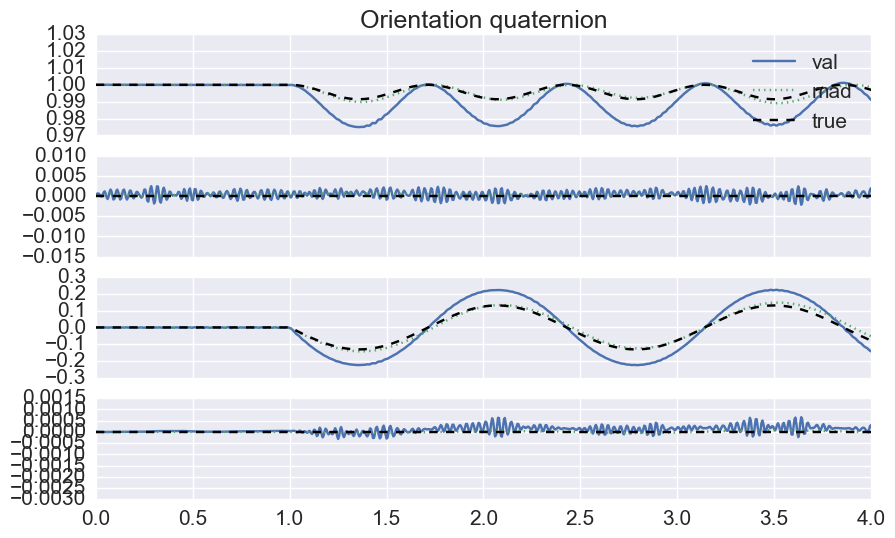

In [31]:
fig, ax = plt.subplots(4,1, sharex=True)
for o0, om, ov, ax1 in zip(np.rollaxis(quaternion.as_float_array(imu.qorient_world_true), 1), 
                                np.rollaxis(quaternion.as_float_array(qorient_mad), 1), 
                                np.rollaxis(quaternion.as_float_array(qorient_val), 1),
                                ax):
    ax1.plot(imu.t, ov, label='val')
    ax1.plot(imu.t, om, ':', label='mad')
    ax1.plot(imu.t, o0, 'k--', label='true')
ax[0].set_title('Orientation quaternion')
ax[0].legend()
ax[0].set_xlim([0, 4])

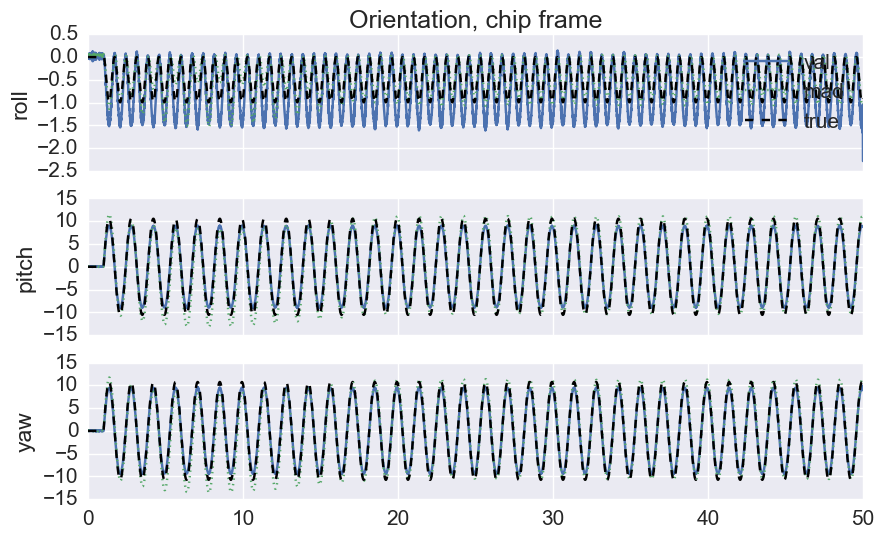

In [21]:
fig, ax = plt.subplots(3,1, sharex=True)
for o0, om, ov, ax1, lab in zip(np.rollaxis(imu.orient_imu_true, 1), 
                                np.rollaxis(orient_mad_chip, 1), 
                                np.rollaxis(orient_val_chip, 1),
                                ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, np.rad2deg(ov), label='val')
    ax1.plot(imu.t, np.rad2deg(om), ':', label='mad')
    ax1.plot(imu.t, o0, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('Orientation, chip frame')
ax[0].legend()
# ax[0].set_xlim([0, 0.5])

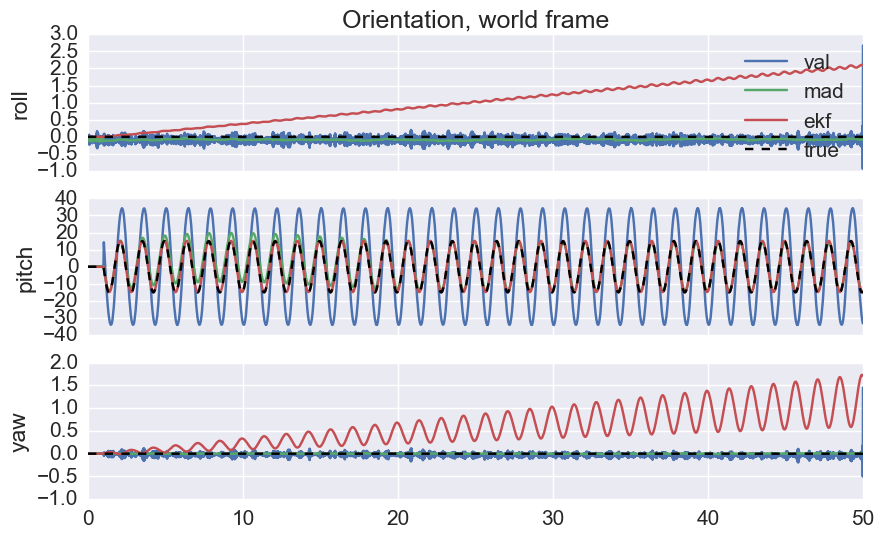

In [54]:
fig, ax = plt.subplots(3,1, sharex=True)
for o0, om, ov, oe, ax1, lab in zip(np.rollaxis(imu.orient_world_true, 1), np.rollaxis(orient_mad, 1), np.rollaxis(orient_val, 1), 
                                np.rollaxis(orient_ekf, 1),
                                ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, np.rad2deg(ov), label='val')
    ax1.plot(imu.t, np.rad2deg(om), label='mad')
    ax1.plot(imu.t, np.rad2deg(oe), label='ekf')
    ax1.plot(imu.t, o0, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('Orientation, world frame')
ax[0].legend()
#ax[0].set_xlim([4.5, 5])

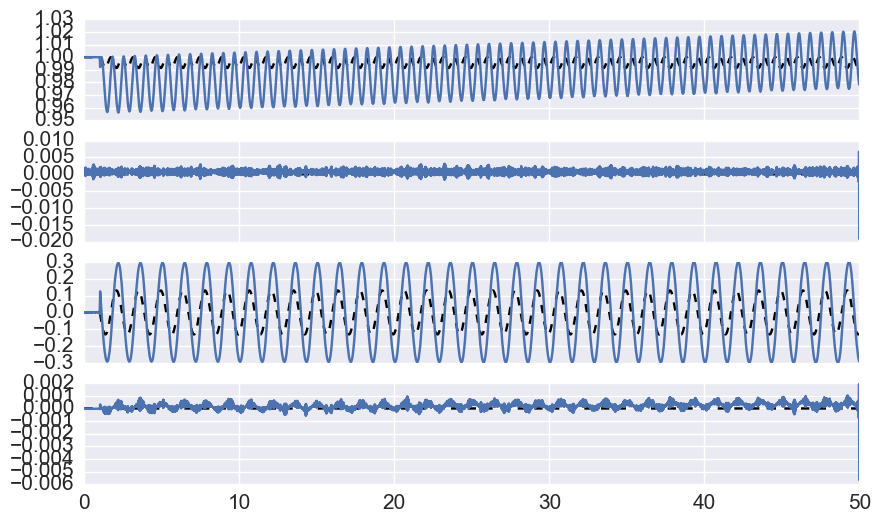

In [55]:
fig, ax = plt.subplots(4,1, sharex=True)
for qw1, qv1, ax1 in zip(np.rollaxis(quaternion.as_float_array(imu.qorient_world_true), 1), 
                         np.rollaxis(quaternion.as_float_array(qorient_val),1), ax):
    ax1.plot(imu.t, qw1, 'k--', label='true')
    ax1.plot(imu.t, qv1, label='val')

In [56]:
qmerr = []
qverr = []
qeerr = []
for i, (q0, qm1, qv1, oe1) in enumerate(zip(imu.qorient_world_true, qorient_mad, qorient_val, orient_ekf)):
    qmerr.append(np.arccos(sum(q0.components * qm1.components)))
    qverr.append(np.arccos(sum(q0.components * qv1.components)))

    qe1 = imu._eul2quat(oe1)
        
    qeerr.append(np.arccos(sum(q0.components * qe1.components)))
    
qmerr = np.array(qmerr)
qverr = np.array(qverr)
qeerr = np.array(qeerr)

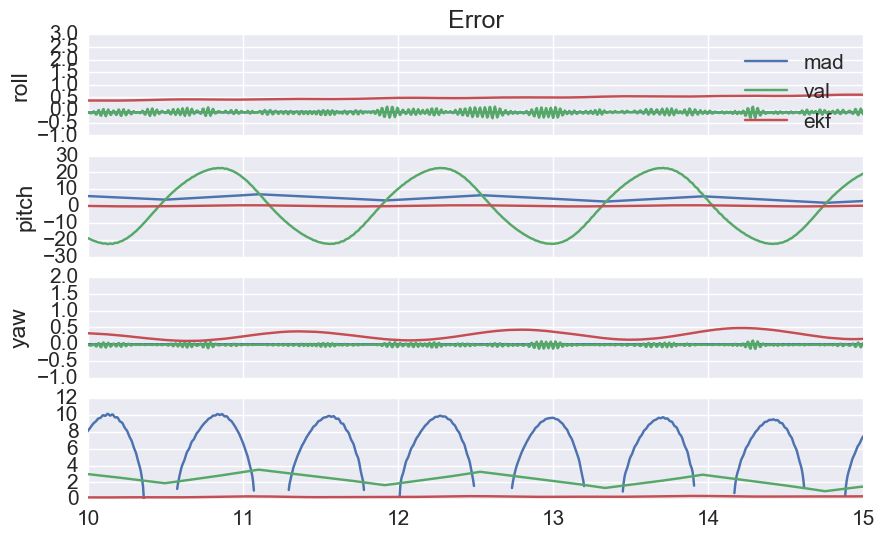

In [57]:
fig, ax = plt.subplots(4,1, sharex=True)

for o0, om, ov, oe, ax1, lab in zip(np.rollaxis(imu.orient_world_true, 1), np.rollaxis(orient_mad, 1), 
                                    np.rollaxis(orient_val, 1), np.rollaxis(orient_ekf, 1),
                                    ax, ['roll', 'pitch', 'yaw']):
    
    ax1.plot(imu.t, np.rad2deg(om)-o0, label='mad')
    ax1.plot(imu.t, np.rad2deg(ov)-o0, label='val')
    ax1.plot(imu.t, np.rad2deg(oe)-o0, label='ekf')
    ax1.set_ylabel(lab)

ax[-1].plot(imu.t, np.rad2deg(qverr), label='val')
ax[-1].plot(imu.t, np.rad2deg(qmerr), label='mad')
ax[-1].plot(imu.t, np.rad2deg(qeerr), label='ekf')

ax[0].set_title('Error')
ax[0].legend()
ax[0].set_xlim([10, 15])

plt.show()

(10, 12)

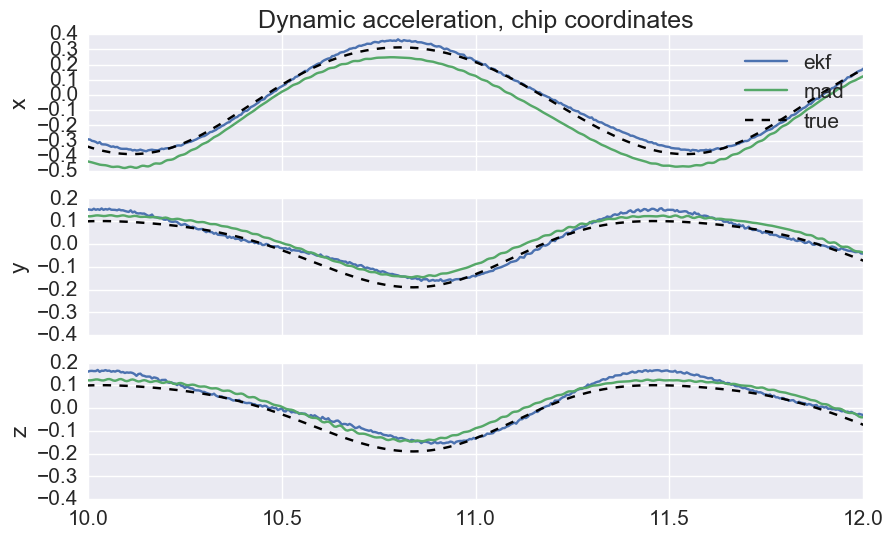

In [58]:
fig, ax = plt.subplots(3,1, sharex=True)
for a0, ae, am, ax1, lab in zip(np.rollaxis(imu.accdyn_imu_true, 1), 
                                    np.rollaxis(accdyn_ekf_chip, 1),
                                    np.rollaxis(accdyn_mad_chip, 1), ax, ['x', 'y', 'z']):
    ax1.plot(imu.t, ae, label='ekf')
    ax1.plot(imu.t, am, label='mad')
    ax1.plot(imu.t, a0, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('Dynamic acceleration, chip coordinates')
ax[0].legend()
ax[0].set_xlim([10, 12])

(10, 12)

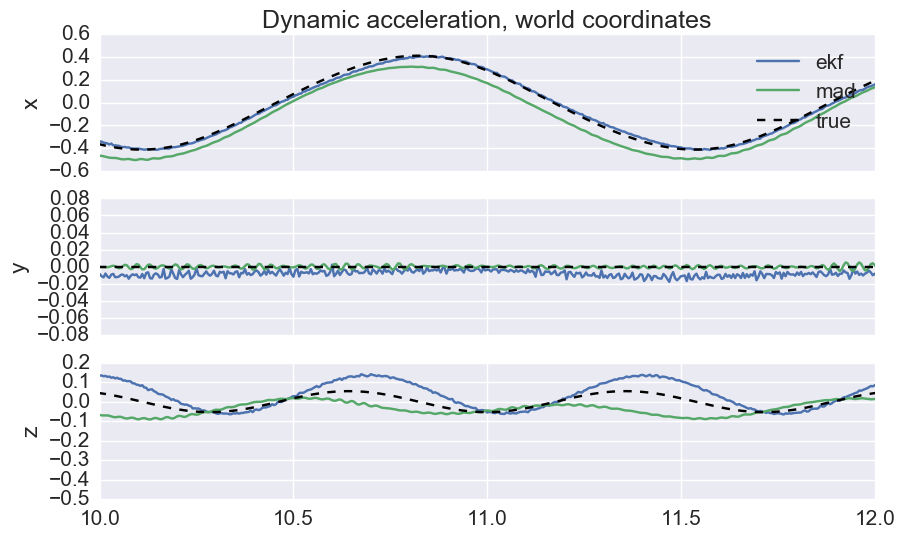

In [59]:
fig, ax = plt.subplots(3,1, sharex=True)
for a0, ae, am, av, ax1, lab in zip(np.rollaxis(imu.accdyn_world_true, 1), 
                                np.rollaxis(accdyn_ekf, 1),
                                np.rollaxis(accdyn_mad, 1),
                                np.rollaxis(accdyn_val, 1)
                                ax, ['x', 'y', 'z']):
    ax1.plot(imu.t, ae, label='ekf')
    ax1.plot(imu.t, am, label='mad')
    ax1.plot(imu.t, a0, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('Dynamic acceleration, world coordinates')
ax[0].legend()
ax[0].set_xlim([10, 12])